<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# start

In [2]:
# installs

In [21]:
# imports
import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
import cv2
from google.colab.patches import cv2_imshow
import glob
import itertools

In [4]:
# loading dataset
# https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

!gdown --id 1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe #loading the dataset from google drive link to colab
!unzip /content/face-mask-12k.zip &> /dev/null #unzipping
!rm -rf /content/face-mask-12k.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe
To: /content/face-mask-12k.zip
351MB [00:02, 163MB/s]


In [20]:
# finding the perfect crop size, for whole dataset
# https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-to-get-image-size

def generate_image_paths(dir_path):
  files_png = glob.glob(dir_path + '/**/*.png', recursive=True)
  paths = list(files_png)
  return paths

train_dataset_path = "/content/face-mask-12k/Train"
val_dataset_path = "/content/face-mask-12k/Validation"

train_paths = generate_image_paths(train_dataset_path)
val_paths = generate_image_paths(val_dataset_path)

print(len(train_paths))
print(len(val_paths))

def find_avg_height_and_width(paths):
  sum_height = 0
  sum_width = 0
  for path in paths:
    image = cv2.imread(path)
    height, width, channels = image.shape
    sum_height += height
    sum_width += width
  avg_height = sum_height//len(paths)
  avg_width = sum_width//len(paths)
  return (avg_height, avg_width)

print("Train avg height and width", find_avg_height_and_width(train_paths))
print("Validation avg height and width", find_avg_height_and_width(val_paths))

10000
800
Train avg height and width (153, 153)
Validation avg height and width (152, 152)


In [24]:
# Preprocessing the data set into list of images
# https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Train",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Validation",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Test",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)
print("Train-dataset-length", len(train_dataset))
print("Validation-dataset-length", len(val_dataset))
print("Test-dataset-length", len(test_dataset))

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Train-dataset-length 313
Validation-dataset-length 25
Test-dataset-length 31


In [ ]:
# Model(Transfer Learning) (Later)

In [26]:
# Adding call Back Functions
# https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
# Main Model 

class MModel:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.model = self.get_model()
    self.train_history = []
    self.val_history = []
    self.test_history = []

  def get_model(self):
    inputs = tf.keras.Input(shape=self.input_shape)  #input layer
    layer1 = tf.keras.layers.Conv2D(
        filters=2,
        kernel_size=4,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(inputs)
    layer2 = tf.keras.layers.Flatten()(layer1)
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(layer2)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.summary()
    plot_model(model, to_file='main_model_V040301.png') #convention for the model plot: main_model_VddMMXX where XX is the model number
    return model

  def compile(self, optimizer="adam", loss="binary_crossentropy", metrics=['acc', f1_m, precision_m, recall_m]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def train(self, train_dataset, epochs=1):
    self.train_history = self.model.fit(train_dataset, epochs=epochs, verbose=1)

  def evaluate(self, val_dataset, batch_size="32"):
    self.val_history = self.model.evaluate(val_dataset, batch_size=32, verbose=1)
  
  def predict(self, val_dataset):
    for images, label in val_dataset:
      prediction = self.model.predict(images, verbose=1)
      for i in range(len(prediction)):
        image = cv2.cvtColor(images[i].numpy(), cv2.COLOR_BGR2RGB)
        cv2_imshow(image)
        if(prediction[i] >= 0.5):
          p = 1
        else:
          p = 0
        print(p,label[i])

In [44]:
# Creating instance of MModel Class

mmodel = MModel((153, 153, 3))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 153, 153, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 2)       98        
_________________________________________________________________
flatten_2 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 45001     
Total params: 45,099
Trainable params: 45,099
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Model Compilation
# https://keras.io/api/models/model_training_apis/

mmodel.compile()

In [46]:
# Training
# https://keras.io/api/models/model_training_apis/

mmodel.train(train_dataset, 1)

313/313 [==============================] - 86s 272ms/step - loss: 107.8136 - acc: 0.7597 - f1_m: 0.7348 - precision_m: 0.7293 - recall_m: 0.7893


In [47]:
# model evaluation
# https://keras.io/api/models/model_training_apis/

mmodel.evaluate(val_dataset)

25/25 [==============================] - 4s 124ms/step - loss: 1.4416 - acc: 0.8625 - f1_m: 0.8668 - precision_m: 0.8450 - recall_m: 0.8965


In [ ]:
# Predictions of single random image
# https://keras.io/api/models/model_training_apis/

# mmodel.predict_random() -> still needs to be written

0 tf.Tensor([1.], shape=(1,), dtype=float32)
1/1 [==============================] - 0s 164ms/step


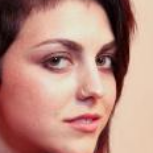

1 tf.Tensor([1.], shape=(1,), dtype=float32)


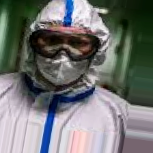

0 tf.Tensor([0.], shape=(1,), dtype=float32)


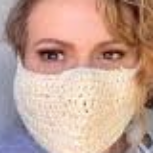

0 tf.Tensor([0.], shape=(1,), dtype=float32)


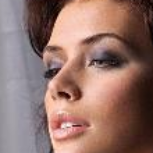

1 tf.Tensor([1.], shape=(1,), dtype=float32)


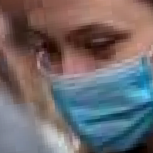

0 tf.Tensor([0.], shape=(1,), dtype=float32)


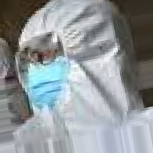

0 tf.Tensor([0.], shape=(1,), dtype=float32)


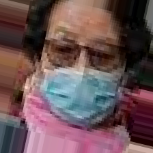

0 tf.Tensor([0.], shape=(1,), dtype=float32)


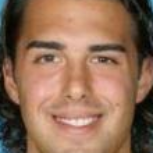

1 tf.Tensor([1.], shape=(1,), dtype=float32)


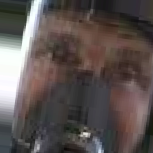

0 tf.Tensor([0.], shape=(1,), dtype=float32)


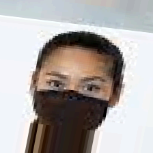

0 tf.Tensor([0.], shape=(1,), dtype=float32)


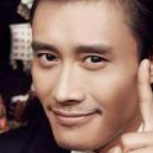

0 tf.Tensor([1.], shape=(1,), dtype=float32)


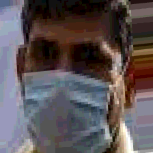

0 tf.Tensor([0.], shape=(1,), dtype=float32)


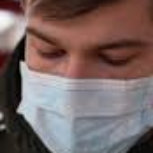

0 tf.Tensor([0.], shape=(1,), dtype=float32)


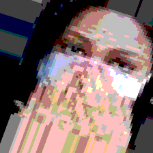

0 tf.Tensor([0.], shape=(1,), dtype=float32)


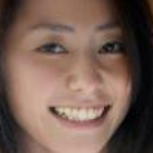

1 tf.Tensor([1.], shape=(1,), dtype=float32)


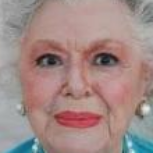

1 tf.Tensor([1.], shape=(1,), dtype=float32)


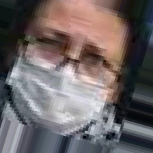

0 tf.Tensor([0.], shape=(1,), dtype=float32)


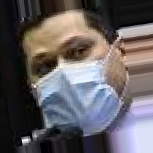

0 tf.Tensor([0.], shape=(1,), dtype=float32)


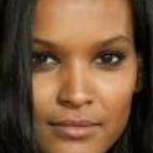

1 tf.Tensor([1.], shape=(1,), dtype=float32)


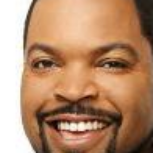

1 tf.Tensor([1.], shape=(1,), dtype=float32)


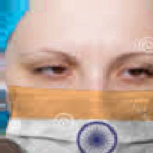

1 tf.Tensor([0.], shape=(1,), dtype=float32)


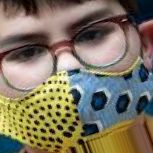

0 tf.Tensor([0.], shape=(1,), dtype=float32)


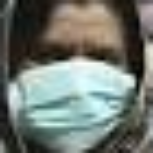

1 tf.Tensor([0.], shape=(1,), dtype=float32)


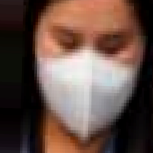

0 tf.Tensor([0.], shape=(1,), dtype=float32)


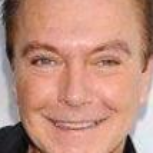

1 tf.Tensor([1.], shape=(1,), dtype=float32)


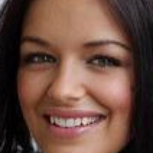

1 tf.Tensor([1.], shape=(1,), dtype=float32)


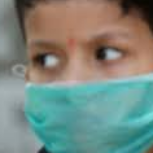

0 tf.Tensor([0.], shape=(1,), dtype=float32)


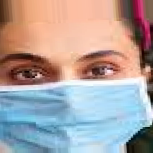

0 tf.Tensor([0.], shape=(1,), dtype=float32)


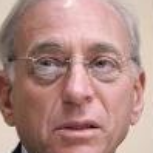

1 tf.Tensor([1.], shape=(1,), dtype=float32)


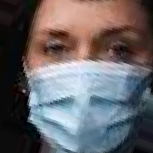

0 tf.Tensor([0.], shape=(1,), dtype=float32)


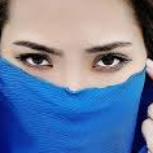

0 tf.Tensor([0.], shape=(1,), dtype=float32)


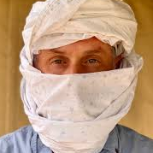

0 tf.Tensor([0.], shape=(1,), dtype=float32)
1/1 [==============================] - 0s 161ms/step


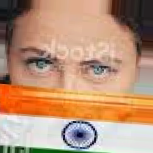

0 tf.Tensor([0.], shape=(1,), dtype=float32)


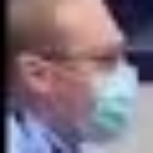

0 tf.Tensor([0.], shape=(1,), dtype=float32)


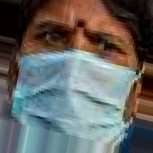

0 tf.Tensor([0.], shape=(1,), dtype=float32)


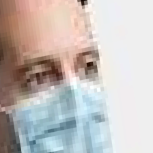

1 tf.Tensor([0.], shape=(1,), dtype=float32)


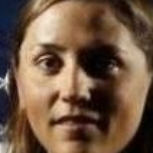

1 tf.Tensor([1.], shape=(1,), dtype=float32)


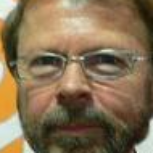

1 tf.Tensor([1.], shape=(1,), dtype=float32)


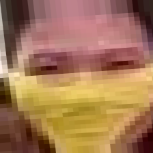

0 tf.Tensor([0.], shape=(1,), dtype=float32)


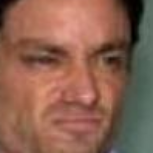

1 tf.Tensor([1.], shape=(1,), dtype=float32)


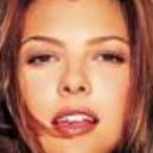

1 tf.Tensor([1.], shape=(1,), dtype=float32)


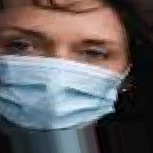

0 tf.Tensor([0.], shape=(1,), dtype=float32)


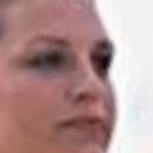

1 tf.Tensor([1.], shape=(1,), dtype=float32)


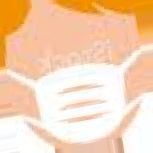

0 tf.Tensor([0.], shape=(1,), dtype=float32)


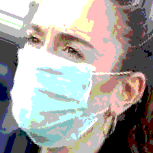

1 tf.Tensor([0.], shape=(1,), dtype=float32)


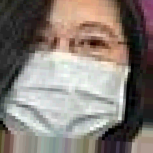

0 tf.Tensor([0.], shape=(1,), dtype=float32)


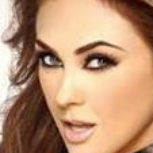

1 tf.Tensor([1.], shape=(1,), dtype=float32)


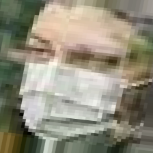

0 tf.Tensor([0.], shape=(1,), dtype=float32)


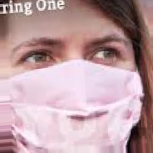

0 tf.Tensor([0.], shape=(1,), dtype=float32)


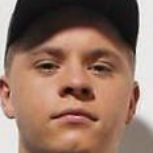

0 tf.Tensor([1.], shape=(1,), dtype=float32)


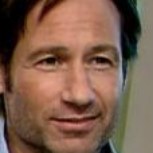

1 tf.Tensor([1.], shape=(1,), dtype=float32)


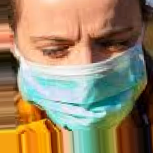

0 tf.Tensor([0.], shape=(1,), dtype=float32)


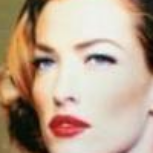

1 tf.Tensor([1.], shape=(1,), dtype=float32)


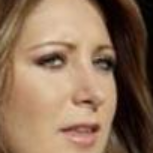

1 tf.Tensor([1.], shape=(1,), dtype=float32)


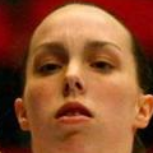

0 tf.Tensor([1.], shape=(1,), dtype=float32)


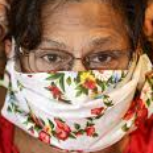

0 tf.Tensor([0.], shape=(1,), dtype=float32)


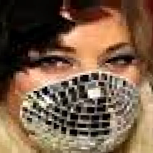

0 tf.Tensor([0.], shape=(1,), dtype=float32)


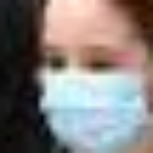

0 tf.Tensor([0.], shape=(1,), dtype=float32)


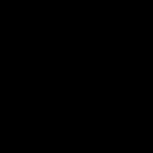

0 tf.Tensor([0.], shape=(1,), dtype=float32)


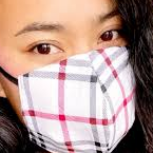

0 tf.Tensor([0.], shape=(1,), dtype=float32)


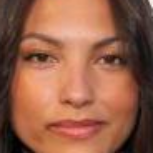

1 tf.Tensor([1.], shape=(1,), dtype=float32)


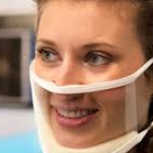

0 tf.Tensor([0.], shape=(1,), dtype=float32)


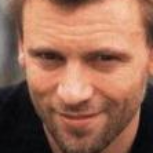

1 tf.Tensor([1.], shape=(1,), dtype=float32)


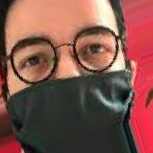

0 tf.Tensor([0.], shape=(1,), dtype=float32)
1/1 [==============================] - 0s 167ms/step


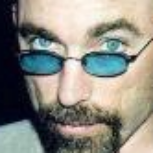

1 tf.Tensor([1.], shape=(1,), dtype=float32)


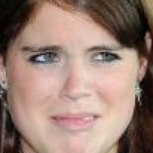

1 tf.Tensor([1.], shape=(1,), dtype=float32)


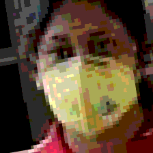

0 tf.Tensor([0.], shape=(1,), dtype=float32)


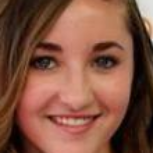

1 tf.Tensor([1.], shape=(1,), dtype=float32)


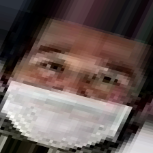

0 tf.Tensor([0.], shape=(1,), dtype=float32)


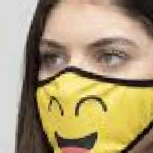

1 tf.Tensor([0.], shape=(1,), dtype=float32)


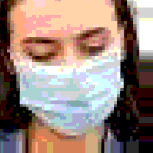

0 tf.Tensor([0.], shape=(1,), dtype=float32)


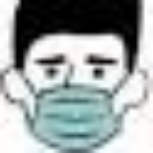

1 tf.Tensor([0.], shape=(1,), dtype=float32)


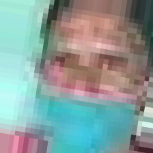

0 tf.Tensor([0.], shape=(1,), dtype=float32)


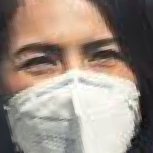

1 tf.Tensor([0.], shape=(1,), dtype=float32)


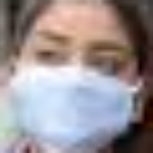

0 tf.Tensor([0.], shape=(1,), dtype=float32)


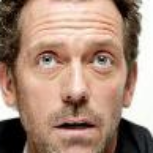

1 tf.Tensor([1.], shape=(1,), dtype=float32)


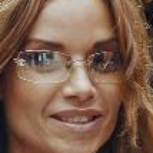

1 tf.Tensor([1.], shape=(1,), dtype=float32)


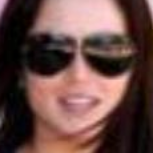

1 tf.Tensor([1.], shape=(1,), dtype=float32)


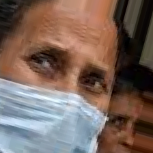

0 tf.Tensor([0.], shape=(1,), dtype=float32)


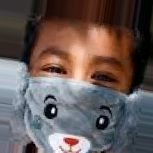

0 tf.Tensor([0.], shape=(1,), dtype=float32)


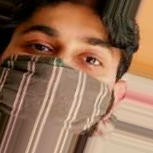

0 tf.Tensor([0.], shape=(1,), dtype=float32)


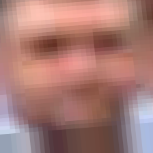

0 tf.Tensor([0.], shape=(1,), dtype=float32)


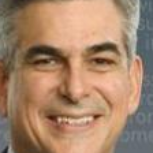

1 tf.Tensor([1.], shape=(1,), dtype=float32)


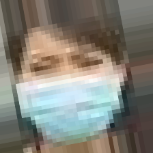

0 tf.Tensor([0.], shape=(1,), dtype=float32)


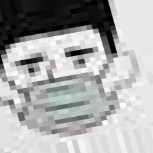

1 tf.Tensor([0.], shape=(1,), dtype=float32)


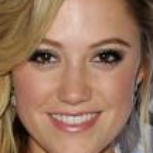

1 tf.Tensor([1.], shape=(1,), dtype=float32)


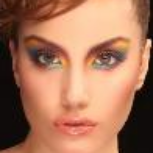

1 tf.Tensor([1.], shape=(1,), dtype=float32)


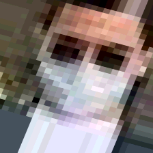

0 tf.Tensor([0.], shape=(1,), dtype=float32)


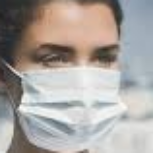

1 tf.Tensor([0.], shape=(1,), dtype=float32)


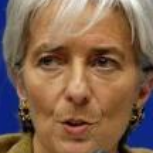

1 tf.Tensor([1.], shape=(1,), dtype=float32)


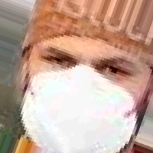

0 tf.Tensor([0.], shape=(1,), dtype=float32)


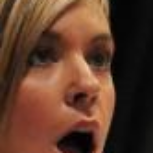

0 tf.Tensor([1.], shape=(1,), dtype=float32)


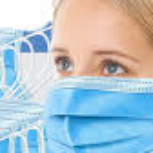

0 tf.Tensor([0.], shape=(1,), dtype=float32)


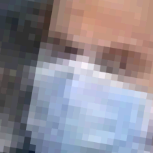

0 tf.Tensor([0.], shape=(1,), dtype=float32)


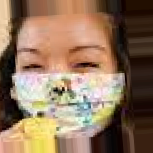

0 tf.Tensor([0.], shape=(1,), dtype=float32)


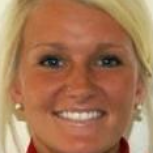

1 tf.Tensor([1.], shape=(1,), dtype=float32)
1/1 [==============================] - 0s 162ms/step


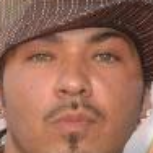

0 tf.Tensor([1.], shape=(1,), dtype=float32)


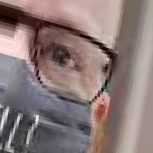

0 tf.Tensor([0.], shape=(1,), dtype=float32)


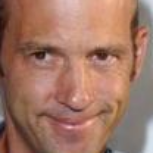

1 tf.Tensor([1.], shape=(1,), dtype=float32)


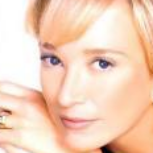

0 tf.Tensor([1.], shape=(1,), dtype=float32)


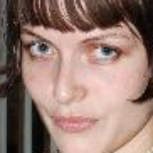

1 tf.Tensor([1.], shape=(1,), dtype=float32)


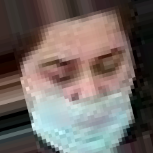

0 tf.Tensor([0.], shape=(1,), dtype=float32)


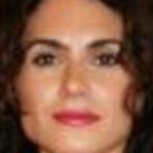

1 tf.Tensor([1.], shape=(1,), dtype=float32)


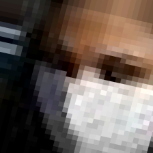

0 tf.Tensor([0.], shape=(1,), dtype=float32)


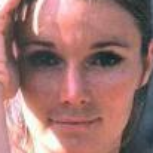

1 tf.Tensor([1.], shape=(1,), dtype=float32)


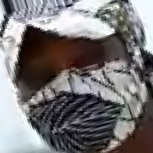

0 tf.Tensor([0.], shape=(1,), dtype=float32)


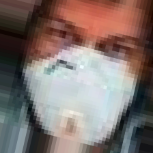

0 tf.Tensor([0.], shape=(1,), dtype=float32)


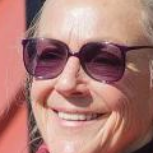

1 tf.Tensor([1.], shape=(1,), dtype=float32)


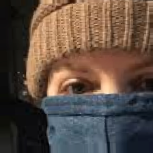

0 tf.Tensor([0.], shape=(1,), dtype=float32)


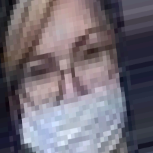

0 tf.Tensor([0.], shape=(1,), dtype=float32)


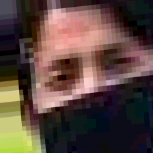

0 tf.Tensor([0.], shape=(1,), dtype=float32)


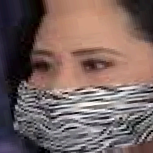

1 tf.Tensor([0.], shape=(1,), dtype=float32)


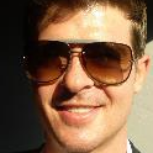

1 tf.Tensor([1.], shape=(1,), dtype=float32)


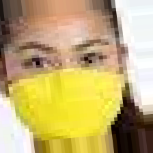

1 tf.Tensor([0.], shape=(1,), dtype=float32)


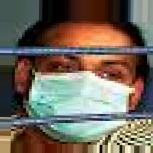

0 tf.Tensor([0.], shape=(1,), dtype=float32)


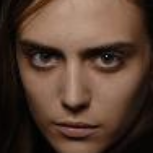

1 tf.Tensor([1.], shape=(1,), dtype=float32)


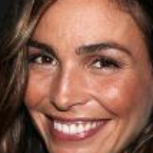

1 tf.Tensor([1.], shape=(1,), dtype=float32)


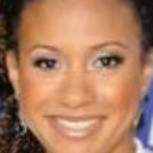

1 tf.Tensor([1.], shape=(1,), dtype=float32)


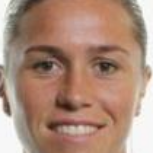

1 tf.Tensor([1.], shape=(1,), dtype=float32)


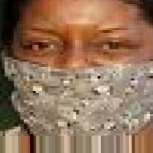

0 tf.Tensor([0.], shape=(1,), dtype=float32)


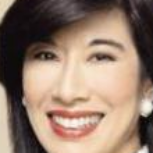

0 tf.Tensor([1.], shape=(1,), dtype=float32)


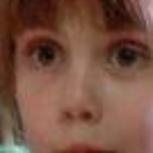

1 tf.Tensor([1.], shape=(1,), dtype=float32)


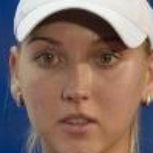

1 tf.Tensor([1.], shape=(1,), dtype=float32)


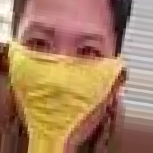

0 tf.Tensor([0.], shape=(1,), dtype=float32)


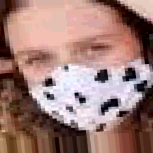

0 tf.Tensor([0.], shape=(1,), dtype=float32)


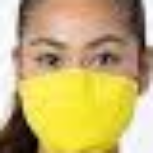

1 tf.Tensor([0.], shape=(1,), dtype=float32)


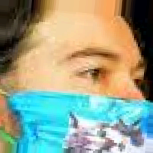

1 tf.Tensor([0.], shape=(1,), dtype=float32)


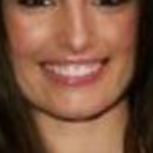

0 tf.Tensor([1.], shape=(1,), dtype=float32)
1/1 [==============================] - 0s 167ms/step


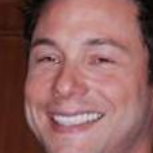

1 tf.Tensor([1.], shape=(1,), dtype=float32)


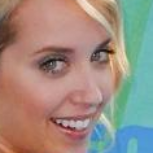

1 tf.Tensor([1.], shape=(1,), dtype=float32)


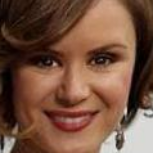

1 tf.Tensor([1.], shape=(1,), dtype=float32)


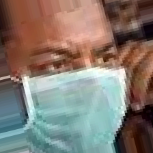

0 tf.Tensor([0.], shape=(1,), dtype=float32)


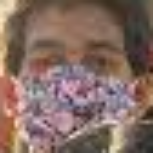

0 tf.Tensor([0.], shape=(1,), dtype=float32)


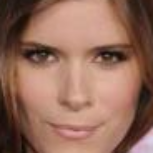

1 tf.Tensor([1.], shape=(1,), dtype=float32)


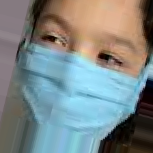

0 tf.Tensor([0.], shape=(1,), dtype=float32)


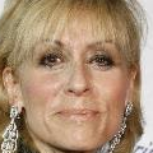

1 tf.Tensor([1.], shape=(1,), dtype=float32)


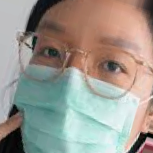

0 tf.Tensor([0.], shape=(1,), dtype=float32)


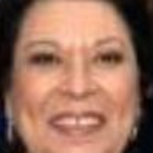

1 tf.Tensor([1.], shape=(1,), dtype=float32)


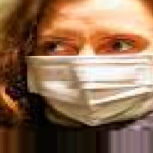

0 tf.Tensor([0.], shape=(1,), dtype=float32)


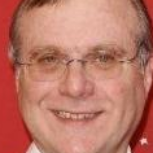

1 tf.Tensor([1.], shape=(1,), dtype=float32)


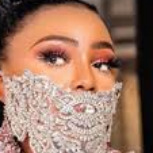

0 tf.Tensor([0.], shape=(1,), dtype=float32)


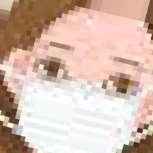

0 tf.Tensor([0.], shape=(1,), dtype=float32)


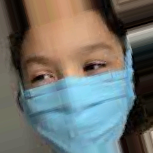

0 tf.Tensor([0.], shape=(1,), dtype=float32)


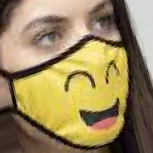

1 tf.Tensor([0.], shape=(1,), dtype=float32)


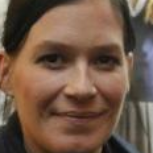

1 tf.Tensor([1.], shape=(1,), dtype=float32)


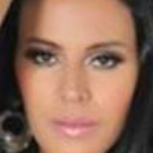

1 tf.Tensor([1.], shape=(1,), dtype=float32)


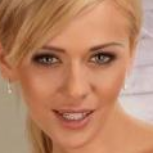

1 tf.Tensor([1.], shape=(1,), dtype=float32)


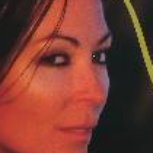

1 tf.Tensor([1.], shape=(1,), dtype=float32)


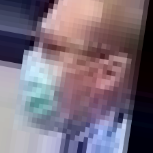

0 tf.Tensor([0.], shape=(1,), dtype=float32)


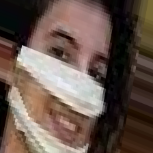

0 tf.Tensor([0.], shape=(1,), dtype=float32)


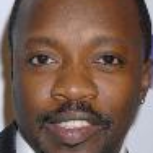

1 tf.Tensor([1.], shape=(1,), dtype=float32)


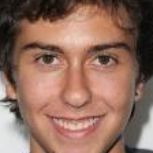

1 tf.Tensor([1.], shape=(1,), dtype=float32)


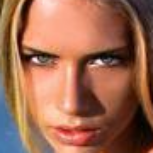

1 tf.Tensor([1.], shape=(1,), dtype=float32)


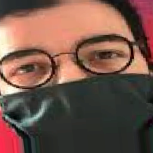

0 tf.Tensor([0.], shape=(1,), dtype=float32)


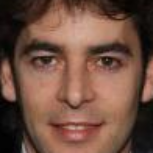

1 tf.Tensor([1.], shape=(1,), dtype=float32)


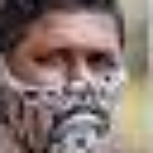

0 tf.Tensor([0.], shape=(1,), dtype=float32)


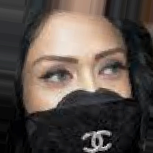

0 tf.Tensor([0.], shape=(1,), dtype=float32)


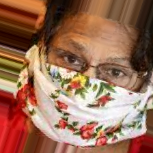

0 tf.Tensor([0.], shape=(1,), dtype=float32)


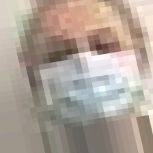

0 tf.Tensor([0.], shape=(1,), dtype=float32)


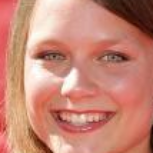

0 tf.Tensor([1.], shape=(1,), dtype=float32)


In [48]:
# Predictions of Validation data set(Dev) -- Vinay

mmodel.predict(val_dataset)

In [ ]:
# Drawing the train and dev Loss and accuracy of the model, visualising too

# mmodel.plot_loss_accuary() -> still needs to be written

In [ ]:
# Calculating the F1-Score of the Model on Dev data set
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

# mmodel.get_f1() -> still needs to be written

In [ ]:
# Visualisation of the F1-Score on Dev data set

# mmodel.plot_f1() -> still needs to be written